In [1]:
import torch
import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import yaml
import argparse
import copy
from diffusion_model import Model 
import torchvision.utils as tvu
import shutil
import glob
import time
import torch.utils.data as data 
import torch.optim as optim

In [2]:
def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

In [3]:
class EMAHelper(object):
    """read about EMA
    exponential moving average (EMA) of model weights
    """
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        if isinstance(module,torch.nn.DataParallel):
            module = module.module
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        if isinstance(module,torch.nn.DataParallel):
            module = module.module
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (
                    1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        if isinstance(module,torch.nn.DataParallel):
            module = module.module
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        if isinstance(module,torch.nn.DataParallel):
            inner_module = module.module
            module_copy = type(inner_module)(
                inner_module.config).to(inner_module.config.device)
            module_copy.load_state_dict(inner_module.state_dict())
            module_copy =torch.nn.DataParallel(module_copy, inner_module.args.dataparallel)
        else:
            module_copy = type(module)(module.config).to(module.config.device)
            module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict

def get_optimizer(config, parameters):
    if config.optim.optimizer == 'Adam':
        return optim.Adam(parameters, lr=config.optim.lr, weight_decay=config.optim.weight_decay,
                          betas=(config.optim.beta1, 0.999), amsgrad=config.optim.amsgrad,
                          eps=config.optim.eps)
    elif config.optim.optimizer == 'RMSProp':
        return optim.RMSprop(parameters, lr=config.optim.lr, weight_decay=config.optim.weight_decay)
    elif config.optim.optimizer == 'SGD':
        return optim.SGD(parameters, lr=config.optim.lr, momentum=0.9)
    else:
        raise NotImplementedError(
            'Optimizer {} not understood.'.format(config.optim.optimizer))
    
def noise_estimation_loss(net, images, labels=None, augment_pipe=None):
    rnd_normal = torch.randn([images.shape[0],], device=images.device)
    P_mean = np.log(args.sigma_start*args.sigma_end)/2
    P_std = np.log(args.sigma_start/args.sigma_end)/2
    sigma = (rnd_normal * P_std + P_mean).exp()
    reshaped_sigma = sigma.reshape(images.shape[0], 1, 1, 1)
    y = images
    n = torch.randn_like(y) * reshaped_sigma
    D_yn = net(y + n, sigma)
    loss = ((D_yn - y) ** 2)
    return loss.mean()

In [112]:
class Diffusion(object):
    def __init__(self, args, config, device=None
                ):
        self.args = args
        self.config = config
        self.sigma_min = args.sigma_end **2 /args.sigma_start
        self.sigma_max = args.sigma_start **2 /args.sigma_end
        self.rho = args.rho
        self.loss_his = []
        self.val_loss_his = []
        self.val_loss_steps = []
        
        if device is None:
            device = (
                self.config.device
                if torch.cuda.is_available()
                else torch.device("cpu")
            )
        self.device = device
        self.num_timesteps = config.diffusion.num_diffusion_timesteps
            
    def round_sigma(self, sigma):
        return torch.as_tensor(sigma)
    
    def sample(self):
        model = Model(self.config)
        if self.args.ckpt_id is None:
            states = torch.load(
                os.path.join(self.args.log_path, "ckpt.pth"),
                map_location=self.config.device,
            )
        else:
            states = torch.load(
                os.path.join(
                    self.args.log_path, f"ckpt_{self.args.ckpt_id}.pth"
                ),
                map_location=self.config.device,
            )
            print('load ckpt: ', self.args.ckpt_id)
            
        model = model.to(self.device)
        model = torch.nn.DataParallel(model, self.args.dataparallel)
#         model = model.to(self.device)
        model.load_state_dict(states[0], strict=True)
        print('load epoch: ', states[3])

        model.eval()

        if self.args.fid:
            self.sample_fid(model)
        elif self.args.interpolation:
            self.sample_interpolation(model)
        elif self.args.sequence:
            self.sample_sequence(model)
        else:
            raise NotImplementedError("Sample procedeure not defined")

    def sample_fid(self, model):
        config = self.config
        img_id = len(glob.glob(f"{self.args.generated_image_folder}/*"))
        print(f"starting from image {img_id}")
        total_n_samples = 1000
        n_rounds = (total_n_samples - img_id) // config.sampling.batch_size

        with torch.no_grad():
            for _ in tqdm.tqdm(
                range(n_rounds), desc="Generating image samples for FID evaluation."
            ):
                n = config.sampling.batch_size
                x = torch.randn(
                    n,
                    config.data.channels,
                    config.data.image_size,
                    config.data.image_size,
                    device=self.device,
                )

                x = self.sample_image(x, model)
#                 x = inverse_data_transform(config, x)
                x = [(y + 1.0) / 2.0 for y in x]
                for i in range(n):
                    tvu.save_image(
                        x[i], os.path.join(self.args.generated_image_folder, f"{img_id}.png")
                    )
                    img_id += 1

    def sample_sequence(self, model, training = False, step = None):
        config = self.config

        x = torch.randn(
            config.sampling.batch_size,
            config.data.channels,
            config.data.image_size,
            config.data.image_size,
            device=self.device,
        )
        
        data_start = time.time()
        data_time = 0
        # NOTE: This means that we are producing each predicted x0, not x_{t-1} at timestep t.
        with torch.no_grad():
            x = self.sample_image(x, model)
        data_time += time.time() - data_start
        print(f"the sample time of {self.config.sampling.batch_size} images takes {data_time}")

#         x = [inverse_data_transform(config, y) for y in x]
        x = [(y + 1.0) / 2.0 for y in x]
#         if not training:
#             for i in range(len(x)):
#                 for j in range(x[i].size(0)):
#                     tvu.save_image(
#                         x[i][j], os.path.join(self.args.image_folder, f"{step}_{j}_{i}.png")
#                     )
        for i in range(20):
            tvu.save_image(x[i], os.path.join(self.args.image_folder, f"generated_{i}.png"))
        if not training:
            plt.figure(figsize=(40, 8))
            
            for i in range(20):
                plt.ioff()
                plt.subplot(2, 10, i+1)
                img = x[i]
                img = img.permute((1, 2, 0)).numpy()
                plt.imshow(np.asarray(img), cmap='gray')
                plt.axis('off')
            plt.savefig(os.path.join(self.args.image_folder, f"generated_image_{self.args.sample_type}_{self.args.skip_type}_{self.args.timesteps}_{data_time}s.png"))  
        
        else:
            plt.figure(figsize=(16, 8))
            
            for i in range(8):
                plt.ioff()
                plt.subplot(2, 4, i+1)
                img = x[i]
                img = img.permute((1, 2, 0)).numpy()
                plt.imshow(np.asarray(img), cmap='gray')
                plt.axis('off')
            plt.savefig(os.path.join(self.args.image_folder, f"{step}.png"))
            
#             tvu.save_image(
#                         x[999,:,:,:,:], os.path.join(self.args.image_folder, f"{step}.png")
#                     )

    def sample_interpolation(self, model):
        config = self.config

        test_dataset = test_images_tensor 
        test_dataset = test_dataset.to(self.device)
        
        
        def slerp(z1, z2, alpha):
            theta = torch.acos(torch.sum(z1 * z2) / (torch.norm(z1) * torch.norm(z2)))
            return (
                torch.sin((1 - alpha) * theta) / torch.sin(theta) * z1
                + torch.sin(alpha * theta) / torch.sin(theta) * z2
            )
        x1 = test_dataset[:1]
        x2 = test_dataset[7:8]
        
        
        x1_save = (x1 + 1.0) / 2.0
        x2_save = (x2 + 1.0) / 2.0
        tvu.save_image(x1_save, os.path.join(self.args.generated_image_folder, f"source_1.png"))
        tvu.save_image(x2_save, os.path.join(self.args.generated_image_folder, f"source_2.png"))
        
         # Time step discretization.
        step_indices = torch.arange(self.args.timesteps, device=self.device)
        t_steps = (args.latent_space_loc ** (1 / self.rho) + step_indices / (self.args.timesteps - 1) * (self.sigma_min ** (1 / self.rho) - args.latent_space_loc ** (1 / self.rho))) ** self.rho
        t_steps = torch.cat([torch.as_tensor(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0
        t_steps = t_steps.flip(0)
        
        z1 = x1 + args.latent_space_loc * torch.randn_like(x1)
        z2 = x2 + args.latent_space_loc * torch.randn_like(x1)
        
#         for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):
#             z1 = z1 + (t_next-t_cur) * torch.randn_like(z1)
#             z2 = z2 + (t_next-t_cur) * torch.randn_like(z2)
        
        z1 = z1/args.latent_space_loc
        z2 = z2/args.latent_space_loc
#         
        alpha = torch.linspace(0.0, 1.01, self.args.interpolation_samples).to(z1.device)
        z_ = []
        for i in range(alpha.size(0)):
            z_.append(slerp(z1, z2, alpha[i]))

        x = torch.cat(z_, dim=0)
        xs = []

        # Hard coded here, modify to your preferences
        with torch.no_grad():
            for i in range(0, x.size(0), 8):
                xs.append(self.sample_image(x[i : i + 8], model))
#         x = inverse_data_transform(config, torch.cat(xs, dim=0))
        x = [(y + 1.0) / 2.0 for y in torch.cat(xs, dim=0)]
        for i in range(len(x)):
            tvu.save_image(x[i], os.path.join(self.args.generated_image_folder, f"{i}.png"))

    def sample_image(self, x, model):
        
        
        data_start = time.time()
        data_time = 0
        if self.args.sample_type == "deterministic":
             x = edm_sampler(latents = x, num_steps = self.args.timesteps, net = model, randn_like=torch.randn_like, sigma_min = self.sigma_min, sigma_max =  self.sigma_max, rho = self.rho )
        elif self.args.sample_type == "stochastic":
             x = edm_sampler(latents = x, num_steps = self.args.timesteps, net = model, randn_like=torch.randn_like, sigma_min = self.sigma_min, sigma_max =  self.sigma_max, rho = self.rho , S_churn=3, S_min= 0, S_max=1000, S_noise=1.001)
        else:
            raise NotImplementedError
        return x
        data_time += time.time() - data_start
        print(data_time)
        
    def test(self):
        pass


In [122]:
def edm_sampler(
    latents, num_steps, net,  class_labels=None, randn_like=torch.randn_like, sigma_min=0.002, sigma_max=80, rho=1,
    S_churn=0, S_min=0, S_max=float('inf'), S_noise=1
):
    
    # Time step discretization.
#     step_indices = torch.arange(num_steps, device=latents.device)
#     t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
#     t_steps = torch.cat([torch.as_tensor(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0

    
    co_step_indice = (args.latent_space_loc**(1 / rho) - sigma_max ** (1 /  rho))*(num_steps - 1)/( sigma_min ** (1 /  rho) -  sigma_max ** (1 /  rho))
    co_step_indice = round(co_step_indice)

    step_indices = torch.arange(num_steps)/num_steps*(num_steps - co_step_indice) + co_step_indice
    t_steps = ( sigma_max ** (1 /  rho) + step_indices / ( num_steps - 1) * ( sigma_min ** (1 /  rho) -  sigma_max ** (1 /  rho))) **  rho
    t_steps = torch.cat([torch.as_tensor(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0
    
    
    print(t_steps)
    # Main sampling loop.
#     x_next = [latents]
    x_next = [latents * t_steps[0]]
    
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])): # 0, ..., N-1
        
        t_cur = torch.ones(x_next[0].shape[0], device=t_cur.device) * t_cur
        t_next = torch.ones(x_next[0].shape[0], device=t_next.device) * t_next
        
        x_cur = x_next[-1]

        # Increase noise temporarily.
        gamma = min(S_churn / num_steps, np.sqrt(2) - 1) if S_min <= t_cur[0] <= S_max else 0
        t_hat = torch.as_tensor(t_cur + gamma * t_cur)
        x_hat = (x_cur + (t_hat[0] ** 2 - t_cur[0] ** 2).sqrt() * S_noise * randn_like(x_cur))
        
        # Euler step.
#         denoised = net(x_hat, t_hat, class_labels).to(torch.float64)
        denoised = net(x_hat, t_hat)
        d_cur = (x_hat - denoised) / t_hat[0]
        x_next_ = x_hat + (t_next[0] - t_hat[0]) * d_cur

        # Apply 2nd order correction.
        if i < num_steps - 1:
            denoised = net(x_next_, t_next)
#             denoised = net(x_next_, t_next, class_labels)
            d_prime = (x_next_ - denoised) / t_next[0]
            x_next_ = x_hat + (t_next[0] - t_hat[0]) * (0.5 * d_cur + 0.5 * d_prime)
        
        x_next.append(x_next_)
        
#         for i, _x_next in enumerate(x_next):
#             tvu.save_image(_x_next, os.path.join("18steps_generation_process", f"generated_step_{i}.png"))
        
    return x_next[-1].cpu()

In [123]:
torch.set_printoptions(sci_mode=False)
args = {
    'config': 'biked_256.yml',
    'seed': 1234,
    'exp': 'result_diffusion_model',
    'doc': 'log_folder',
    'comment': "",
    'verbose': "info",
    'sequence': False,
    'test': False,
    'sample': True,
    'fid': False,
    'interpolation': True,
    'resume_training': False,
    'image_folder': "result_diffusion_model/images",
    'generated_image_folder': "interpolation_start",
    'ni': False,
    'use_pretrained': False,
    'sample_type': "deterministic",
#     deterministic, stochastic
    'timesteps': 18,
    'eta': 0.0,
    'dataparallel': [0,1,2,3],
    'ckpt_id': '109000',
#     'skip': 500,
    'rho' : 7,
#     'skip': 500,
    'sigma_start' : 5.3,
    'sigma_end' : 0.6,
    'interpolation_samples': 20
}

args ['latent_space_loc'] = args['sigma_start']
args['log_path']=os.path.join(args['exp'], "logs", args['doc'])
args = dict2namespace(args)
with open(args.config, "r") as f:
    config = yaml.safe_load(f)
config['tb_logger'] = None
config = dict2namespace(config)
tb_path = os.path.join(args.exp, "tensorboard", args.doc)

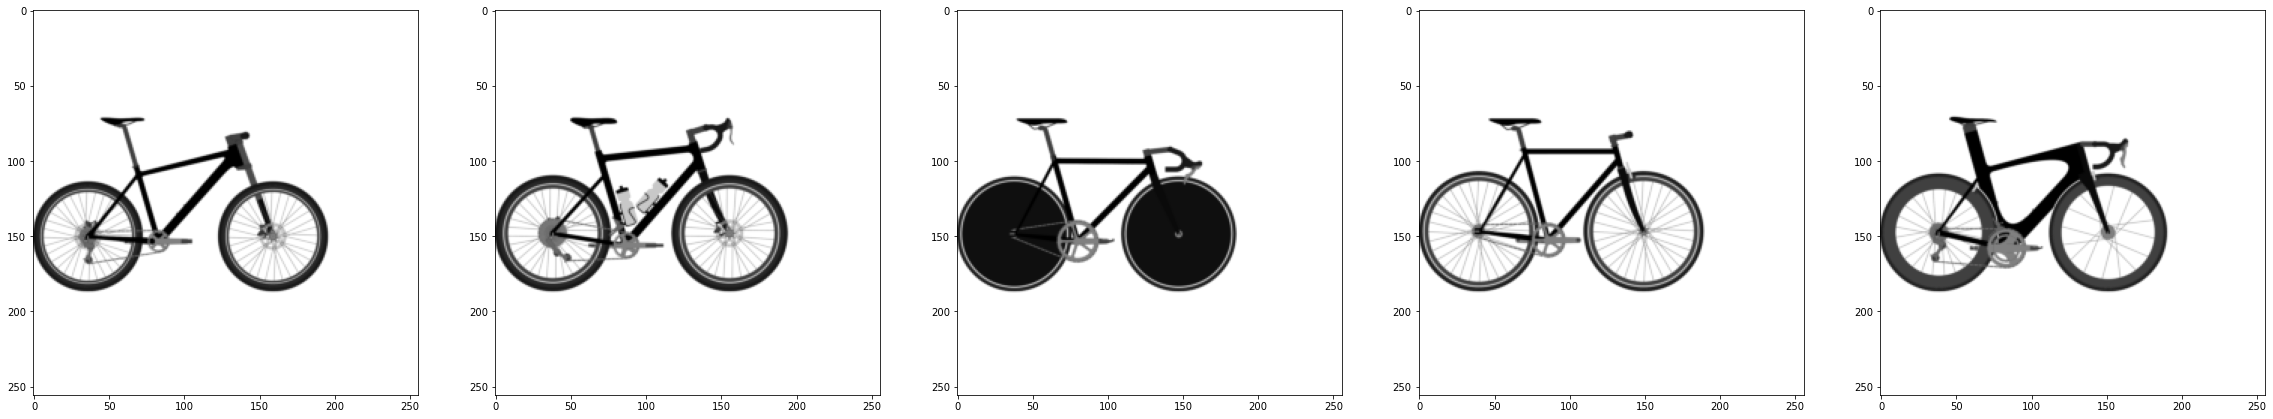

In [124]:
if not args.test and not args.sample:
    train_images = np.load('/home/q603750/q603750/Datasets/BIKED Dataset/rescaled_biked/biked_train_256.npy', mmap_mode='r')
    val_images = np.load('/home/q603750/q603750/Datasets/BIKED Dataset/rescaled_biked/biked_val_256.npy', mmap_mode='r')
    train_images = train_images/0.5-1
    val_images = val_images/0.5-1
    print(train_images.shape)
    print("train image data range: {", train_images[:100].min(),"~",train_images[:100].max(),"}")
    print(val_images.shape)
    print("train image data range: {", val_images.min(),"~",val_images.max(),"}")
    train_images_tensor = torch.tensor(train_images)
    train_images_tensor = train_images_tensor.permute((0, 3, 1, 2))
    val_images_tensor = torch.tensor(val_images)
    val_images_tensor = val_images_tensor.permute((0,3, 1, 2))
    plotting_images = train_images
    del train_images

else:
    test_images = np.load('/home/q603750/q603750/00_Datasets/BIKED Dataset/biked_test_256.npy', mmap_mode='r')
    test_images = test_images/0.5-1
    test_images_tensor = torch.tensor(test_images)
    test_images_tensor = test_images_tensor.permute((0,3, 1, 2))
    plotting_images = test_images
    del test_images

plt.figure(figsize=(40, 200))
plt.subplot(1, 5, 1)
plt.imshow(plotting_images[0, :, :, 0], cmap='gray')
plt.subplot(1, 5, 2)
plt.imshow(plotting_images[1, :, :, 0], cmap='gray')
plt.subplot(1, 5, 3)
plt.imshow(plotting_images[2, :, :, 0], cmap='gray')
plt.subplot(1, 5, 4)
plt.imshow(plotting_images[3, :, :, 0], cmap='gray')
plt.subplot(1, 5, 5)
plt.imshow(plotting_images[4, :, :, 0], cmap='gray')

In [125]:
# torch_device = "cuda:" + str(args.dataparallel[0])
torch_device = "cuda"
device = torch.device(torch_device) if torch.cuda.is_available() else torch.device("cpu")
print("Using device: {}".format(device))
config.device = device

# set random seed
torch.manual_seed(args.seed)
np.random.seed(args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(args.seed)

torch.backends.cudnn.benchmark = True

Using device: cuda


In [126]:
runner = Diffusion(args, config, config.device)
runner.sample()
# runner.test()
# runner.train()

load ckpt:  109000
load epoch:  109000
tensor([6.2554, 5.0878, 4.1122, 3.3015, 2.6319, 2.0822, 1.6340, 1.2712, 0.9798,
        0.7476, 0.5642, 0.4209, 0.3099, 0.2251, 0.1610, 0.1132, 0.0781, 0.0528,
        0.0000])
tensor([6.2554, 5.0878, 4.1122, 3.3015, 2.6319, 2.0822, 1.6340, 1.2712, 0.9798,
        0.7476, 0.5642, 0.4209, 0.3099, 0.2251, 0.1610, 0.1132, 0.0781, 0.0528,
        0.0000])
tensor([6.2554, 5.0878, 4.1122, 3.3015, 2.6319, 2.0822, 1.6340, 1.2712, 0.9798,
        0.7476, 0.5642, 0.4209, 0.3099, 0.2251, 0.1610, 0.1132, 0.0781, 0.0528,
        0.0000])


In [51]:
x1 = test_images_tensor[0].view(1,1,256,256)

 # Time step discretization.
step_indices = torch.arange(18, device=device)
t_steps = (80 ** (1 / 5) + step_indices / (18 - 1) * (0.002 ** (1 / 5) - 80 ** (1 / 5))) ** 5
t_steps = torch.cat([torch.as_tensor(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0
t_steps = t_steps.flip(0)
latents = []
for k in range(1):
        
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):
        z1 = (t_next-t_cur) * torch.randn_like(z1).cuda()
#     z1 = x1
#     z1 = z1 + 80 * torch.randn_like(z1)
    z1 = z1/80
    latents.append(z1.cpu())
    

plt.figure(figsize=(50, 10))
# Plotting the curves
x= range(256*256)
for latent in latents:
    plt.plot(x, latent.flatten())

    
# Adding labels and a legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Multiple Curves in One Plot')

# Display the plot
plt.show()

NameError: name 'z1' is not defined

In [ ]:
x1 = test_images_tensor[4].view(1,1,256,256)

 # Time step discretization.
step_indices = torch.arange(18, device=device)
t_steps = (80 ** (1 / 5) + step_indices / (18 - 1) * (0.002 ** (1 / 5) - 80 ** (1 / 5))) ** 5
t_steps = torch.cat([torch.as_tensor(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0
t_steps = t_steps.flip(0)
latents = []
for k in range(5):
        
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):
        z1 = z1.cuda() + (t_next-t_cur) * torch.randn_like(z1).cuda()
#     z1 = x1
#     z1 = z1 + 80 * torch.randn_like(z1)
    z1 = z1/80
    latents.append(z1.cpu())
    

# Plotting the curves
x= range(256*256)
for latent in latents:
    plt.plot(x, latent.flatten())

# Adding labels and a legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Multiple Curves in One Plot')

# Display the plot
plt.show()

In [ ]:
timesteps = 18
sigma_max = 80
sigma_min = 0.002
rho = 7

step_indices = torch.arange(timesteps).cpu()
t_steps = (sigma_max ** (1 / rho) + step_indices / (timesteps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
t_steps = torch.cat([torch.as_tensor(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0

x = range(t_steps.shape[0])

plt.plot(x, t_steps)

# Adding labels and a legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Multiple Curves in One Plot')

# Display the plot
plt.show()
        

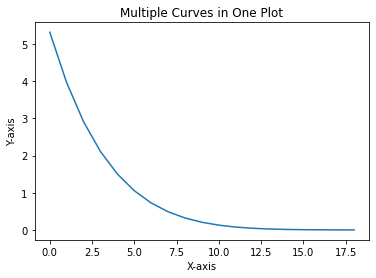

In [111]:
sigma_semantic_max = 5
timesteps = 18
sigma_max = 80
sigma_min = 0.002
rho = 7
co_step_indice = (sigma_semantic_max**(1 / rho) - sigma_max ** (1 /  rho))*(timesteps - 1)/( sigma_min ** (1 /  rho) -  sigma_max ** (1 /  rho))
co_step_indice = round(co_step_indice)

step_indices = torch.arange(timesteps)/timesteps*(timesteps - co_step_indice) + co_step_indice
t_steps = ( sigma_max ** (1 /  rho) + step_indices / ( timesteps - 1) * ( sigma_min ** (1 /  rho) -  sigma_max ** (1 /  rho))) **  rho
t_steps = torch.cat([torch.as_tensor(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0
x = range(t_steps.shape[0])

plt.plot(x, t_steps)

# Adding labels and a legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Multiple Curves in One Plot')

# Display the plot
plt.show()
        